<a href="https://colab.research.google.com/github/rohanchaudhary21/E-Commerce-Dashboard-Power-BI/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# Load the CSV file
flights_df = pd.read_csv('/content/data/Flight Level Data.csv')
bags_df = pd.read_csv('/content/data/Bag+Level+Data.csv')
pnr_flight_df = pd.read_csv('/content/data/PNR+Flight+Level+Data.csv')
pnr_remarks_df = pd.read_csv('/content/data/PNR Remark Level Data.csv')
airports_df = pd.read_csv('/content/data/Airports Data.csv')

# 1. Exploratory Data Analysis (EDA)


## What is the average delay and what percentage of flights depart later than scheduled?


In [ ]:
flights_df['scheduled_departure_datetime_local'] = pd.to_datetime(flights_df['scheduled_departure_datetime_local'])
flights_df['actual_departure_datetime_local'] = pd.to_datetime(flights_df['actual_departure_datetime_local'])

# Calculate the departure delay in minutes
# A positive value indicates a late departure, a negative value indicates an early departure.
flights_df['departure_delay_minutes'] = (flights_df['actual_departure_datetime_local'] - flights_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60

# --- 1. Calculate the average delay ---
# We consider 'delay' to be the calculated difference.
# Average is the mean of this column.
average_delay = flights_df['departure_delay_minutes'].mean()

# --- 2. Calculate the percentage of flights that depart later than scheduled ---
# A flight departs later than scheduled if the departure_delay_minutes > 0
late_departures_count = flights_df[flights_df['departure_delay_minutes'] > 0].shape[0]
total_flights = flights_df.shape[0]
percentage_late_departures = (late_departures_count / total_flights) * 100

print(f"Average Departure Delay: {average_delay:.2f} minutes")
print(f"Percentage of Flights Departing Later than Scheduled: {percentage_late_departures:.2f}%")

Average Departure Delay: 21.18 minutes
Percentage of Flights Departing Later than Scheduled: 49.61%


## How many flights have scheduled ground time close to or below the minimum turn mins?

In [20]:
# Load the Flight Level Data
df_flight = pd.read_csv('/content/data/Flight Level Data.csv')

# Count the number of flights where scheduled ground time is less than or equal to
# the minimum turn time required.
tight_ground_time_count = df_flight[
    df_flight['scheduled_ground_time_minutes'] <= df_flight['minimum_turn_minutes']
].shape[0]

print(f"Number of flights with scheduled ground time close to or below the minimum turn mins: {tight_ground_time_count}")

Number of flights with scheduled ground time close to or below the minimum turn mins: 652


## What is the average ratio of transfer bags vs. checked bags across flights?


In [ ]:
bags_df = pd.read_csv('/content/data/Bag+Level+Data.csv')

# --- Core Logic for Calculation ---

# 1. Create a unique flight identifier (Airline + Flight Number)
bags_df['Flight_ID'] = bags_df['company_id'] + bags_df['flight_number'].astype(str)

# 2. Count 'Transfer' and 'Checked' bags for each unique flight
# unstack() converts the Bag_Type values into new columns
bag_counts = bags_df.groupby('Flight_ID')['bag_type'].value_counts().unstack(fill_value=0)

# Ensure both 'Checked' and 'Transfer' columns exist, filling with 0 if a flight had none of that type
if 'Checked' not in bag_counts.columns:
    bag_counts['Checked'] = 0
if 'Transfer' not in bag_counts.columns:
    bag_counts['Transfer'] = 0

# Reorder columns for clarity
bag_counts = bag_counts[['Transfer', 'Checked']]

# 3. Calculate the ratio of Transfer bags vs Checked bags for each flight
# Add a very small constant (epsilon) to the denominator to prevent division by zero,
# which occurs for flights that have 0 checked bags.
epsilon = 1e-30
bag_counts['Transfer_vs_Checked_Ratio'] = bag_counts['Transfer'] / (bag_counts['Checked'] + epsilon)

# 4. Calculate the average of these ratios across all flights
average_ratio = bag_counts['Transfer_vs_Checked_Ratio'].mean()

print("Bag Counts and Ratios per Flight:")
print(bag_counts)
print("\n" + "="*50)
print(f"Average Ratio of Transfer bags vs Checked bags across flights: {average_ratio}")

Bag Counts and Ratios per Flight:
bag_type   Transfer  Checked  Transfer_vs_Checked_Ratio
Flight_ID                                              
4Y52              1        0               1.000000e+30
9X305             2        0               2.000000e+30
9X330             1        0               1.000000e+30
9X332             1        0               1.000000e+30
9X361             3        0               3.000000e+30
...             ...      ...                        ...
YX3707          369        0               3.690000e+32
YX3708          124        0               1.240000e+32
YX3715           73        0               7.300000e+31
YX3716          650        0               6.500000e+32
YX3718          501        0               5.010000e+32

[1377 rows x 3 columns]

Average Ratio of Transfer bags vs Checked bags across flights: 2.5239360929557008e+32


## How do passenger loads compare across flights, and do higher loads correlate with operational difficulty?


--- Load Factor Distribution (Descriptive Statistics) ---
count    8099.000000
mean        1.024236
std         0.209837
min         0.060000
25%         0.940000
50%         1.047619
75%         1.145251
max         1.895000
Name: load_factor, dtype: float64

--- Correlation Results ---
Pearson Correlation Coefficient (Load Factor vs. Delay): -0.1502


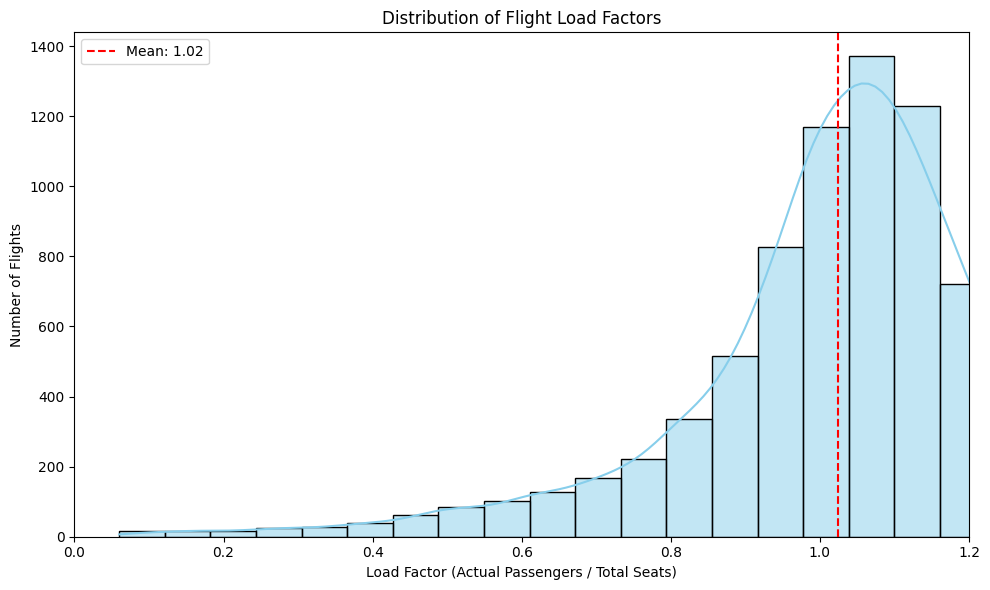

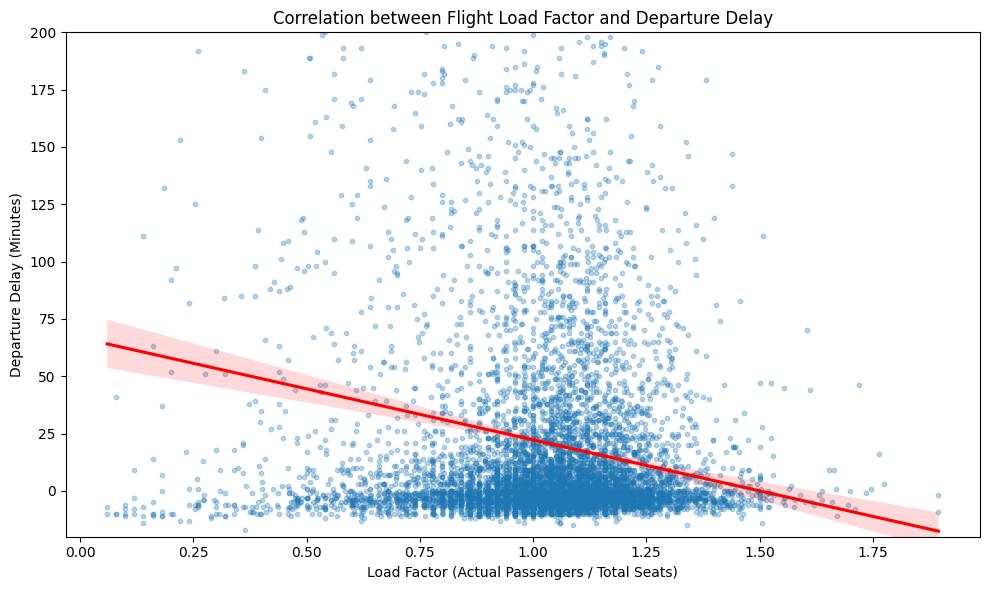

In [17]:
# Define the unique flight key columns
flight_key = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# --- 1. Data Preparation and Merging ---

# Load PNR data and aggregate total passengers per flight
df_pax = pd.read_csv('/content/data/PNR+Flight+Level+Data.csv')
df_pax_agg = df_pax.groupby(flight_key)['total_pax'].sum().reset_index()
df_pax_agg.rename(columns={'total_pax': 'actual_pax_count'}, inplace=True)

# Load Flight data, calculate delay, and select necessary columns
df_flight = pd.read_csv('/content/data/Flight Level Data.csv')
df_flight['scheduled_departure_datetime_local'] = pd.to_datetime(df_flight['scheduled_departure_datetime_local'])
df_flight['actual_departure_datetime_local'] = pd.to_datetime(df_flight['actual_departure_datetime_local'])
df_flight['departure_delay_minutes'] = (
    df_flight['actual_departure_datetime_local'] - df_flight['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

df_flight_slim = df_flight[flight_key + ['total_seats', 'departure_delay_minutes']]

# Merge the dataframes
df_merged = pd.merge(df_flight_slim, df_pax_agg, on=flight_key, how='inner')

# Calculate Load Factor
df_merged['load_factor'] = df_merged['actual_pax_count'] / df_merged['total_seats']
df_analysis = df_merged[df_merged['total_seats'] > 0].copy()


# --- 2. Load Factor Comparison (Question 1) ---

# Descriptive Statistics
print("--- Load Factor Distribution (Descriptive Statistics) ---")
print(df_analysis['load_factor'].describe())

# Visualization: Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_analysis['load_factor'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Flight Load Factors')
plt.xlabel('Load Factor (Actual Passengers / Total Seats)')
plt.ylabel('Number of Flights')
plt.xlim(0, 1.2)
plt.axvline(df_analysis['load_factor'].mean(), color='red', linestyle='--', label=f'Mean: {df_analysis["load_factor"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('load_factor_distribution.png')


# --- 3. Correlation with Operational Difficulty (Question 2) ---

# Calculate Correlation
correlation = df_analysis['load_factor'].corr(df_analysis['departure_delay_minutes'])
print("\n--- Correlation Results ---")
print(f"Pearson Correlation Coefficient (Load Factor vs. Delay): {correlation:.4f}")

# Visualization: Scatter Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='load_factor', y='departure_delay_minutes', data=df_analysis, scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
plt.title('Correlation between Flight Load Factor and Departure Delay')
plt.xlabel('Load Factor (Actual Passengers / Total Seats)')
plt.ylabel('Departure Delay (Minutes)')
plt.ylim(-20, 200)
plt.tight_layout()
plt.savefig('load_factor_delay_correlation.png')

## Are high special service requests flights also high-delay after controlling for load?


In [19]:
# Define the unique flight key columns for merging
flight_key = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# --- Step 1: Calculate SSR Count per Flight ---
# Load PNR Remark Data (SSR data)
df_ssr = pd.read_csv('/content/data/PNR Remark Level Data.csv')
# Load PNR Flight Data to map record_locator to flight
df_pnr_flight = pd.read_csv('/content/data/PNR+Flight+Level+Data.csv')

# Select key columns from PNR Flight data
df_pnr_flight_slim = df_pnr_flight[flight_key + ['record_locator', 'total_pax']].drop_duplicates()

# Merge SSR data with PNR flight data
# Drop 'flight_number' from df_ssr to avoid column name conflict
df_ssr_slim = df_ssr.drop(columns=['flight_number'])
df_ssr_merged = pd.merge(df_ssr_slim, df_pnr_flight_slim, on='record_locator', how='inner')

# Aggregate to count total SSRs per flight
df_ssr_count = df_ssr_merged.groupby(flight_key).size().reset_index(name='ssr_count')


# --- Step 2: Calculate Delay and Load Factor per Flight ---
df_flight = pd.read_csv('/content/data/Flight Level Data.csv')

# Calculate Departure Delay
df_flight['scheduled_departure_datetime_local'] = pd.to_datetime(df_flight['scheduled_departure_datetime_local'])
df_flight['actual_departure_datetime_local'] = pd.to_datetime(df_flight['actual_departure_datetime_local'])
df_flight['departure_delay_minutes'] = (
    df_flight['actual_departure_datetime_local'] - df_flight['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# Aggregate total passengers
df_pax_agg = df_pnr_flight_slim.groupby(flight_key)['total_pax'].sum().reset_index()
df_pax_agg.rename(columns={'total_pax': 'actual_pax_count'}, inplace=True)

# Merge flight data with passenger data
df_base = pd.merge(df_flight, df_pax_agg, on=flight_key, how='inner')

# Calculate Load Factor (handling total_seats=0)
df_base['load_factor'] = np.where(
    df_base['total_seats'] > 0,
    df_base['actual_pax_count'] / df_base['total_seats'],
    0
)


# --- Step 3: Final Merge and Data Cleaning ---
df_model = pd.merge(df_base, df_ssr_count, on=flight_key, how='left')
df_model['ssr_count'] = df_model['ssr_count'].fillna(0) # Fill flights with no SSRs with 0

# Select variables and drop any remaining NaNs
df_analysis = df_model[['departure_delay_minutes', 'load_factor', 'ssr_count']].dropna()


# --- Step 4: Multiple Linear Regression Analysis ---

# Dependent variable (Y) and Independent variables (X)
Y = df_analysis['departure_delay_minutes']
X = df_analysis[['load_factor', 'ssr_count']]

# Add a constant (intercept) to the predictor set
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(Y, X).fit()

print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     departure_delay_minutes   R-squared:                       0.036
Model:                                 OLS   Adj. R-squared:                  0.035
Method:                      Least Squares   F-statistic:                     150.0
Date:                     Sat, 04 Oct 2025   Prob (F-statistic):           1.06e-64
Time:                             06:56:53   Log-Likelihood:                -44792.
No. Observations:                     8099   AIC:                         8.959e+04
Df Residuals:                         8096   BIC:                         8.961e+04
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------


# 2. Flight Difficulty Score Development
Build a systematic daily-level scoring approach that resets every day. Below are the outputs required:

Ranking: Within each day, order flights by their difficulty score so that the highest-ranked flights represent the most difficult to manage.

Classification: Group flights into three categories — Difficult, Medium, or Easy — based on rank distribution.

In [24]:
import pandas as pd
import numpy as np

# --- Configuration ---
# Define the unique flight key used across all datasets
FLIGHT_KEY = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# Classification thresholds based on daily rank percentile
# Top 10% (0.10) is Difficult
# Top 40% (0.40) is Medium (includes the Difficult 10% + the next 30%)
CLASSIFICATION_THRESHOLDS = {'Difficult': 0.10, 'Medium': 0.40}

def load_data():
    """Loads all necessary dataframes."""
    print("Loading data files...")
    try:
        # Load all required files for the analysis
        df_flight = pd.read_csv('/content/data/Flight Level Data.csv')
        df_pnr_flight = pd.read_csv('/content/data/PNR+Flight+Level+Data.csv')
        df_ssr = pd.read_csv('/content/data/PNR Remark Level Data.csv')
        df_bag = pd.read_csv('/content/data/Bag+Level+Data.csv')
        return df_flight, df_pnr_flight, df_ssr, df_bag
    except FileNotFoundError as e:
        print(f"Error: One or more required files not found: {e}")
        # Return empty frames to allow graceful exit later
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

def aggregate_data(df_pnr_flight, df_ssr, df_bag):
    """Aggregates bag and SSR counts to the flight level."""

    # 1. SSR Count Aggregation
    # Map SSRs (by record_locator) to the flight using PNR Flight Data
    df_pnr_flight_slim = df_pnr_flight[FLIGHT_KEY + ['record_locator']].drop_duplicates()

    # Drop flight_number from SSR data to ensure correct merge on record_locator
    df_ssr_slim = df_ssr.drop(columns=['flight_number'])
    df_ssr_merged = pd.merge(df_ssr_slim, df_pnr_flight_slim, on='record_locator', how='inner')

    # Count total SSRs per flight
    df_ssr_count = df_ssr_merged.groupby(FLIGHT_KEY).size().reset_index(name='ssr_count')

    # 2. Bag Counts Aggregation (Transfer and Checked/Origin)
    # Pivot table to count bag types per flight
    df_bag_counts = df_bag.pivot_table(
        index=FLIGHT_KEY,
        columns='bag_type',
        aggfunc='size',
        fill_value=0
    ).reset_index()
    df_bag_counts.rename(columns={'Origin': 'checked_bags_count', 'Transfer': 'transfer_bags_count'}, inplace=True)

    return df_ssr_count, df_bag_counts

def calculate_difficulty_scores(df_flight, df_ssr_count, df_bag_counts):
    """Merges all data, calculates risk factors, standardizes them, and computes the final score."""
    print("Calculating and standardizing risk metrics...")

    # 1. Merge Base Data
    df_analysis = df_flight[FLIGHT_KEY + ['total_seats', 'scheduled_ground_time_minutes', 'minimum_turn_minutes']].copy()

    df_analysis = pd.merge(df_analysis, df_ssr_count, on=FLIGHT_KEY, how='left')
    df_analysis = pd.merge(df_analysis, df_bag_counts, on=FLIGHT_KEY, how='left')

    # Fill NaNs for counts (flights with no records found) with 0
    df_analysis[['ssr_count', 'checked_bags_count', 'transfer_bags_count']] = \
        df_analysis[['ssr_count', 'checked_bags_count', 'transfer_bags_count']].fillna(0)

    df_analysis['flight_date'] = df_analysis['scheduled_departure_date_local']

    # --- 2. Calculate Base Risk Factors ---

    # 2a. Tight Turnaround Risk (Binary Risk: 1 if scheduled ground time is too short)
    df_analysis['tight_turnaround_risk'] = np.where(
        df_analysis['scheduled_ground_time_minutes'] <= df_analysis['minimum_turn_minutes'], 1, 0
    )

    # 2b. SSR per Seat Ratio (Risk of high special handling load)
    df_analysis['ssr_per_seat'] = np.where(
        df_analysis['total_seats'] > 0, df_analysis['ssr_count'] / df_analysis['total_seats'], 0
    )

    # 2c. Transfer Bag Ratio (Risk of complex baggage handling)
    df_analysis['transfer_bag_ratio'] = np.where(
        df_analysis['checked_bags_count'] > 0,
        df_analysis['transfer_bags_count'] / df_analysis['checked_bags_count'],
        0
    )

    # --- 3. Standardization (Z-Score) ---
    # Log(1+x) transformation is used to handle the right-skewness of ratios before Z-scoring.
    risk_cols_to_standardize = ['ssr_per_seat', 'transfer_bag_ratio']

    for col in risk_cols_to_standardize:
        # Log transformation: log(1 + x)
        log_col = f'log_1_{col}'
        df_analysis[log_col] = np.log1p(df_analysis[col])

        # Z-score calculation (across the entire dataset)
        mean_val = df_analysis[log_col].mean()
        std_val = df_analysis[log_col].std()

        # Z-score is the standardized component used in the final score
        df_analysis[f'{col}_zscore'] = (df_analysis[log_col] - mean_val) / std_val

    # --- 4. Final Difficulty Score Calculation ---
    # Score is the sum of standardized risk factors and the binary risk
    df_analysis['difficulty_score'] = (
        df_analysis['ssr_per_seat_zscore'] +
        df_analysis['transfer_bag_ratio_zscore'] +
        df_analysis['tight_turnaround_risk']
    )

    return df_analysis

def rank_and_classify(df_analysis):
    """Applies daily ranking and classification based on rank distribution."""
    print("Ranking and classifying flights...")

    # 5a. Daily Ranking
    # Rank within each day (PARTITION BY flight_date) based on score (DESC)
    df_analysis['daily_rank'] = df_analysis.groupby('flight_date')['difficulty_score'].rank(
        method='min', ascending=False
    )

    # 5b. Total Flights per Day (needed for percentile calculation)
    df_analysis['total_daily_flights'] = df_analysis.groupby('flight_date')['flight_number'].transform('count')

    # 5c. Classification
    def classify_flight_by_rank(row):
        """Classifies the flight based on its rank percentile using defined thresholds."""

        # Calculate rank percentile (e.g., 1st rank in 100 flights = 0.01)
        rank_percentile = row['daily_rank'] / row['total_daily_flights']

        if rank_percentile <= CLASSIFICATION_THRESHOLDS['Difficult']:
            return 'Difficult' # Top 10%
        elif rank_percentile <= CLASSIFICATION_THRESHOLDS['Medium']:
            return 'Medium'    # Next 30% (Ranks > 10% up to 40%)
        else:
            return 'Easy'      # Remaining 60%

    df_analysis['difficulty_classification'] = df_analysis.apply(classify_flight_by_rank, axis=1)

    return df_analysis

def main():
    # Load dataframes
    df_flight, df_pnr_flight, df_ssr, df_bag = load_data()

    # Check if files were loaded correctly
    if df_flight.empty or df_pnr_flight.empty or df_ssr.empty or df_bag.empty:
        print("Analysis terminated due to missing data files.")
        return

    # Aggregate counts
    df_ssr_count, df_bag_counts = aggregate_data(df_pnr_flight, df_ssr, df_bag)

    # Calculate scores
    df_scores = calculate_difficulty_scores(df_flight, df_ssr_count, df_bag_counts)

    # Rank and classify
    df_ranked = rank_and_classify(df_scores)

    # Select final required output columns and sort
    df_final_ranking = df_ranked[
        ['flight_date', 'company_id', 'flight_number', 'difficulty_score', 'daily_rank', 'difficulty_classification']
    ].sort_values(by=['flight_date', 'daily_rank'])

    # --- Final Output Display ---
    print("\n" + "="*70)
    print("--- Daily Flight Difficulty Ranking and Classification ---")
    print("="*70)
    print("\nRanking Key (Resets Daily):")
    print(f"- Difficult: Top {CLASSIFICATION_THRESHOLDS['Difficult']*100:.0f}% of flights by score on a given day.")
    print(f"- Medium: Next {(CLASSIFICATION_THRESHOLDS['Medium'] - CLASSIFICATION_THRESHOLDS['Difficult'])*100:.0f}% of flights.")
    print("- Easy: Remaining flights.")

    print("\nExample Daily Ranking (First 15 Flights):")
    print(df_final_ranking.head(100).to_markdown(index=False, floatfmt=".4f"))

if __name__ == "__main__":
    main()


Loading data files...
Calculating and standardizing risk metrics...
Ranking and classifying flights...

--- Daily Flight Difficulty Ranking and Classification ---

Ranking Key (Resets Daily):
- Difficult: Top 10% of flights by score on a given day.
- Medium: Next 30% of flights.
- Easy: Remaining flights.

Example Daily Ranking (First 15 Flights):
| flight_date   | company_id   |   flight_number |   difficulty_score |   daily_rank | difficulty_classification   |
|:--------------|:-------------|----------------:|-------------------:|-------------:|:----------------------------|
| 2025-08-01    | OO           |            5603 |             5.4002 |       1.0000 | Difficult                   |
| 2025-08-01    | OO           |            4748 |             5.1869 |       2.0000 | Difficult                   |
| 2025-08-01    | G7           |            4542 |             4.9816 |       3.0000 | Difficult                   |
| 2025-08-01    | G7           |            4518 |             4.